In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sl

import seaborn as sns; sns.set()
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
%matplotlib inline

In [3]:
def RK4(X0, t0, dt, func): # actualiza un pasito
    k1 = dt * func(X0, t0)
    k2 = dt * func(X0+k1/2, t0+dt/2)
    k3 = dt * func(X0+k2/2, t0+dt/2)
    k4 = dt * func(X0+k3, t0 + dt)
    return X0 + (k1+2*k2+2*k3+k4)/6

In [4]:
# Oscilador armonico forzado
# d^2x/dt^2 = -omega^2*x+F(t)
# X = (x, v)
# dX/dt = (v, -omega^2*x+F(t)) === F(X, t)
# Solo necesito las condiciones iniciales....
# de X = (x0, v0)
omega2 = 1
f = lambda t: 2 * np.cos(3*t-2)
def F(X, t): # la derivada de X con respecto a t
    global omega2
    global f
    # X = (x, v)
    return np.array([X[1], -omega2*X[0]+f(t)])

dt = 0.0001
t = np.arange(0,30.,dt)
y0 = np.array([0,0]) # limitacion <-
y_temp = y0
y = []
for idx,_t in enumerate(t):
    if idx == 0:
        y.append(y_temp.copy())
    else:
        # y_temp = y_n-1
        y_temp = RK4(y_temp, _t, dt, F)
        # y_temp = y_n
        y.append(y_temp.copy())
y = np.array(y)

In [5]:
x = y[:,0] # posiciones
v = y[:,1] # velocidades

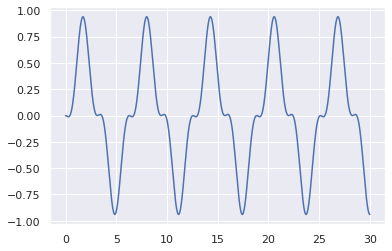

In [6]:
plt.plot(t, x)

# Verlet implementation

In [27]:
def verlet(X0, X1, t1, dt, func):
    # X1 es el punto anterior y t1 el tiempo
    # X0 es entonces el punto anterior a X1, t0 = t1-dt
    # func es la segunda derivada de X con respecto a t
    X2 = 2*X1-X0+func(X1, t1)*dt*dt
    return X2
def verlet_primer_punto(X0, dt, V0):
    X1 = X0 + V0*dt
    return X1

In [35]:
# Oscilador armonico forzado
# d^2x/dt^2 = -omega^2*x+F(t)
omega2 = 1
f = lambda t: 2 * np.cos(3*t-2)
def F(X, t): # la derivada de X con respecto a t
    global omega2
    global f
    # X = (x, v)
    return -omega2*X+f(t)

In [36]:
dt = 0.0001
t = np.arange(0,30.,dt)
y0 = np.array([0,0]) # limitacion <-

y_temp0 = y0[0]
vy0 = y0[1]
y_temp1 = None
y_verlet = []
for idx,_t in enumerate(t):
    if idx == 0:
        y_verlet.append(y_temp.copy())
    elif idx == 1:
        y_temp1 = verlet_primer_punto(y_temp0, dt, vy0) # O(dt^3)
        y_verlet.append(y_temp1)
    else:
        # y_temp = 2*y_temp1-y_temp0+a1*dt^2
        y_temp2 = verlet(y_temp0, y_temp1, _t, dt, F)
        # y_temp = y_n
        y_verlet.append(y_temp2)
        y_temp0 = y_temp1
        y_temp1 = y_temp2
y_verlet = np.array(y_verlet)

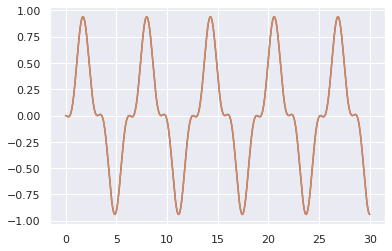

In [38]:
plt.plot(t, y_verlet)
plt.plot(t,x)